# Training Models 

#### We’d like to examine the impact of the input variables, so we will be testing two distinct feature selection setups. The two feature selection setups are as follows:-

* STMFWI using spatial, temporal, the four FWI components and the 3 weather variables (RH, wind, temp)
* FWI with the four FWI components (FFMC , DMC, DC, ISI)

In [54]:
# Load Necessary Libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from numpy import argmax, arange

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.inspection import permutation_importance

import joblib

np.random.seed(123)

In [55]:
sns.set_theme(context = 'notebook', style = 'white', palette = None, font_scale = 1)            

In [56]:
## Load preprocessed file

Xy_train = pd.read_csv('./forest_fires_wrangled_train.csv', sep=',')
Xy_test = pd.read_csv('./forest_fires_wrangled_test.csv', sep=',')

In [57]:
features = list(Xy_train.drop(columns = 'area').columns)

In [58]:
# Separating outcome and explanatory variables into their resp. datasets

X_train = pd.DataFrame(Xy_train[features])
y_train = pd.DataFrame(Xy_train['area'])
X_test = pd.DataFrame(Xy_test[features])
y_test = pd.DataFrame(Xy_test['area'])

# Feature Scaling (Robust Transformation)

#### We know we have outliers present in our data set, hence we will apply Robust scaling to normalize the data features and to make it robust to outliers at the same time .

#### This is useful for algorithms (KNN, SVM, etc) which are based on measures like distance. Also it can speed up our algorithm and suppress the affect of remaining outliers.

In [59]:
scale_cols = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']

#### We  will not scale 'X' and 'Y' as they already represent a form of ordinal encoding for spatial data. Also, we will exclude sin and cos terms of our encoded variables for 'month' and 'day' as they are already scaled.

In [60]:
rs = RobustScaler()
rs.fit(X_train[scale_cols])    
X_train[scale_cols] = rs.transform(X_train[scale_cols])
X_test[scale_cols] = rs.transform(X_test[scale_cols])

In [61]:
X_test.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,day_sin,day_cos,month_sin,month_cos
0,4,4,1.225215,-0.800285,1.256571,-0.906667,-1.125828,0.277324,0.666667,7.818315e-01,0.62349,1.000000,6.123234e-17
1,6,5,0.185662,-0.199715,-0.528858,0.000000,-0.543046,0.704340,0.333333,-7.818315e-01,0.62349,-1.000000,-1.836970e-16
2,8,6,-0.329034,0.182596,-0.075089,0.053333,-0.225166,0.669025,-0.814815,-7.818315e-01,0.62349,-1.000000,-1.836970e-16
3,7,4,-1.279765,-0.171184,1.128099,12.720000,0.198675,0.189025,0.185185,-2.449294e-16,1.00000,0.500000,-8.660254e-01
4,3,4,0.113040,0.486448,0.240802,0.586667,0.039735,-0.050140,0.518519,-2.449294e-16,1.00000,-0.866025,-5.000000e-01


In [62]:
y_train

,area
0,0.000000
1,0.000000
2,1.504077
3,0.000000
4,0.000000
...,...
354,1.121678
355,0.000000
356,1.686399
357,3.919396


In [63]:
# Converting the outcome variable since our model algorithms expects it as 1-d array

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_train.shape

(359,)

--------------------------

# Modelling (STMFWI Setup)

### Linear Regression

#### We will first try to fit a simple linear regression for the full model (STMFWI setup) and assess its performance using R square (R2) metric.
#### We will fit and evaluate our model using 'RepeatedKfold' and so as to get an average score across the different folds and then compare the different results by repeating the experiment 15 times.  The mean result for this is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

#### Note: A single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

>1 mean=-0.0358 se=0.054
>2 mean=-0.0509 se=0.048
>3 mean=-0.0600 se=0.073
>4 mean=-0.0545 se=0.065
>5 mean=-0.0509 se=0.059
>6 mean=-0.0512 se=0.071
>7 mean=-0.0447 se=0.072
>8 mean=-0.0411 se=0.069
>9 mean=-0.0485 se=0.070
>10 mean=-0.0480 se=0.069
>11 mean=-0.0509 se=0.071
>12 mean=-0.0508 se=0.070
>13 mean=-0.0510 se=0.068
>14 mean=-0.0517 se=0.072
>15 mean=-0.0509 se=0.072


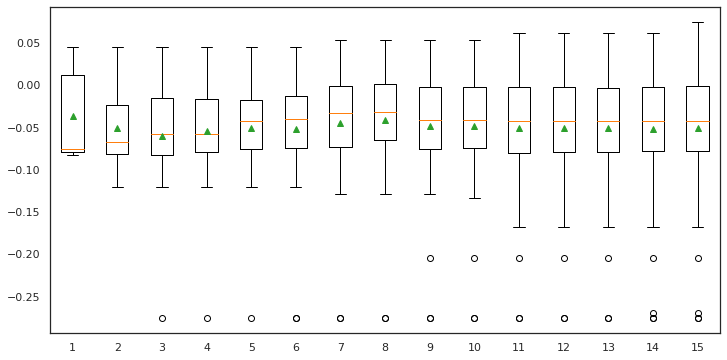

In [64]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
# prepare the cross-validation procedure
    fold = RepeatedKFold(n_splits = 5, n_repeats = repeats, random_state = 3)
# create model
    model = LinearRegression()
# evaluate model
    scores = cross_val_score(model, X, y, scoring = 'r2', cv = fold, n_jobs = -1)
    return scores 

# configurations to test
repeats = range(1,16)
results = list()
for r in repeats:
    # evaluate using a given number of repeats
    scores = evaluate_model(X_train, y_train, r)
    # summarize
    print('>%d mean=%.4f se=%.3f' % (r, np.mean(scores), np.std(scores)))
    # store
    results.append(scores)

# plot the results
plt.figure(figsize = (12,6))
plt.boxplot(results, labels = [str(r) for r in repeats], showmeans = True)
plt.show()

#### The orange line indicates the median of the distribution and the green triangle represents the arithmetic mean. If these symbols (values) coincide, it suggests a reasonable symmetric distribution and that the mean may capture the central tendency well.

#### This might provide an additional heuristic for choosing an appropriate number of repeats for your test harness. Here, We can see that the mean seems to coalesce around a value of about 5%. We might take this as the stable estimate of model performance and in turn, choose 5 or 6 repeats that seem to approximate this value first.

In [65]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print('Linear Regression: R^2 score on training set', round(reg.score(X_train, y_train),3))
print('Linear Regression: R^2 score on test set', round(reg.score(X_test, y_test),3))

Linear Regression: R^2 score on training set 0.05
Linear Regression: R^2 score on test set -0.063


In [66]:
y_predict_te = reg.predict(X_test)

In [67]:
print('Mean Absolute Deviation (MAD):', mean_absolute_error(y_test, y_predict_te))

Mean Absolute Deviation (MAD): 1.1536814227933563


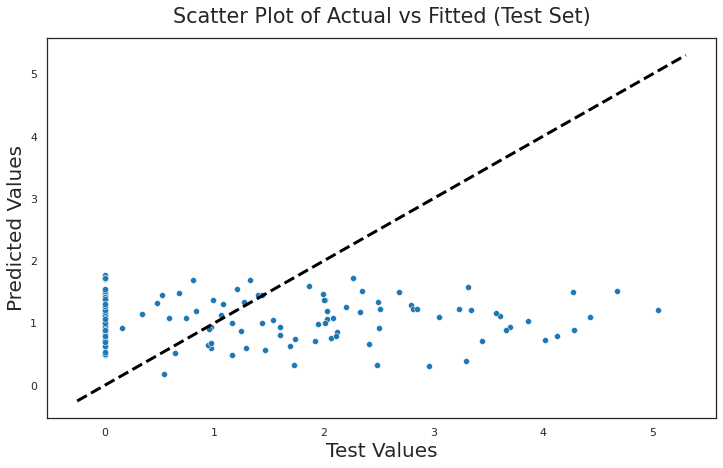

In [68]:
plt.figure(figsize = (12,7))
ax = sns.scatterplot(x = y_test, y = y_predict_te)
xpoints = ypoints = plt.xlim()
ax.plot(xpoints, ypoints, linestyle ='--', color = 'k', lw = 3)
ax.set_xlabel("Test Values", fontsize = 20)
ax.set_ylabel("Predicted Values", fontsize = 20)
plt.title('Scatter Plot of Actual vs Fitted (Test Set)', size = "xx-large", pad = 15)
plt.show()

#### From the above plot we can make out that our linear model does not provide a good fit at all and a different model might better represent our data set. 

#### Note: A good fit would have all the points close to the 45 degree diagnoal line.

## Non Linear Models

#### We will now try fitting non-linear models on our data and assess their performance. We will compare Support Vector Regression (SVR) with Gaussian-RBF kernel, Random Forest (RF) and Gradient Boosting (GB) as our non-linear models.

#### We will use Mean Absolute Deviation Error (MAD) as primary metric and Root Mean Squared Error (RMSE) as secondary metric to assess our models. In both metrics, lower values result in better predictive models. However, note that the RMSE is more sensitive to high errors (outliers). We will also use the Regression Error Characteristic (REC) curve to compare our models, which plots the error tolerance (x-axis), given in terms of the absolute deviation, versus accuracy i.e. the percentage of points predicted within the tolerance (y-axis). The REC curve is used to compare the predictive ability of fitted models. The ideal regressor should present a REC area close to 1.0

#### Note: That R-squared for nonlinear models cannot be used because the research literature shows that it is an invalid goodness-of-fit statistic for this type of model. There are bad consequences if you use it in this context. The reason being in nonlinear regression, SS Regression + SS Error do not equal SS Total which completely invalidates R-squared for nonlinear models, and it no longer has to be between 0 and 100%.

## Grid Search for the 3 Models

#### We will first train and test our Data Mining (DM) algorithm on STMFWI setup i.e. using spatial, temporal, the four FWI components and 3 weather variables.

#### We will train our model using ‘Grid Search’ and try to find the most optimal parameters for our model. Also, we have applied a 5-fold cross validation with 3 replications in our Grid Search’ to each configuration to assess the predictive performances.

#### Note: We use 'RepeatedKFold' as a single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results. Thus Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model as the mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model.

In [69]:
fold = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 7)
metrics_def = {'MAE':'neg_mean_absolute_error', 'RMSE': 'neg_root_mean_squared_error'}
all_GR = dict()

## Support Vector Machine (Gaussian) Grid Search

In [70]:
model = SVR(kernel = 'rbf')
gamma = [0.03,0.05,0.07,0.1,0.5,1,3]
c = [0.05,0.1,0.5,1,3,5,10]
param_grid = dict(gamma = gamma, C = c)

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_SVR = GR.fit(X_train,y_train)

idx = argmax(GR_SVR.cv_results_['mean_test_MAE'])

result = {key : round((GR_SVR.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_SVR.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_SVR.cv_results_['params'][idx]
all_GR['SVR'] = pd.Series(result)

print("Best MAE score: %f using %s "%(GR_SVR.best_score_,GR_SVR.best_params_))

Best MAE score: -1.100917 using {'C': 3, 'gamma': 0.03} 


#### Using grid search we obtained the best parameters for our SVR model with MAE score of 1.101 for train set. Now we will check feature importance for the train set by our model.

In [71]:
def perm_imp(model, x, y, title = 'Feature Importance', n_repeats = 10, random_state = 42, n_jobs = 2):
    
    perm_importance = permutation_importance(model, x, y)
    sorted_idx = perm_importance.importances_mean.argsort()
   
    fig, ax = plt.subplots(2, 1, figsize = (12, 12))
    ax = ax.flatten()        
    
    feature_imp = pd.Series(perm_importance.importances_mean, index = features).sort_values(ascending = True)
    
    ax1 = feature_imp.plot(kind = 'barh', ax = ax[0])
    ax1.set_xlabel("Relative Importance", fontsize = 20)
    ax1.set_ylabel("Feature", fontsize = 20)
    
    ax2 = plt.boxplot(perm_importance.importances[sorted_idx].T, 
                  vert = False, labels = x.columns[sorted_idx])
    plt.xlabel("Relative Importance", fontsize = 20)
    plt.ylabel("Feature", fontsize = 20)
    
    fig.suptitle(title, size = 'xx-large')            
    plt.tight_layout()
    plt.show()

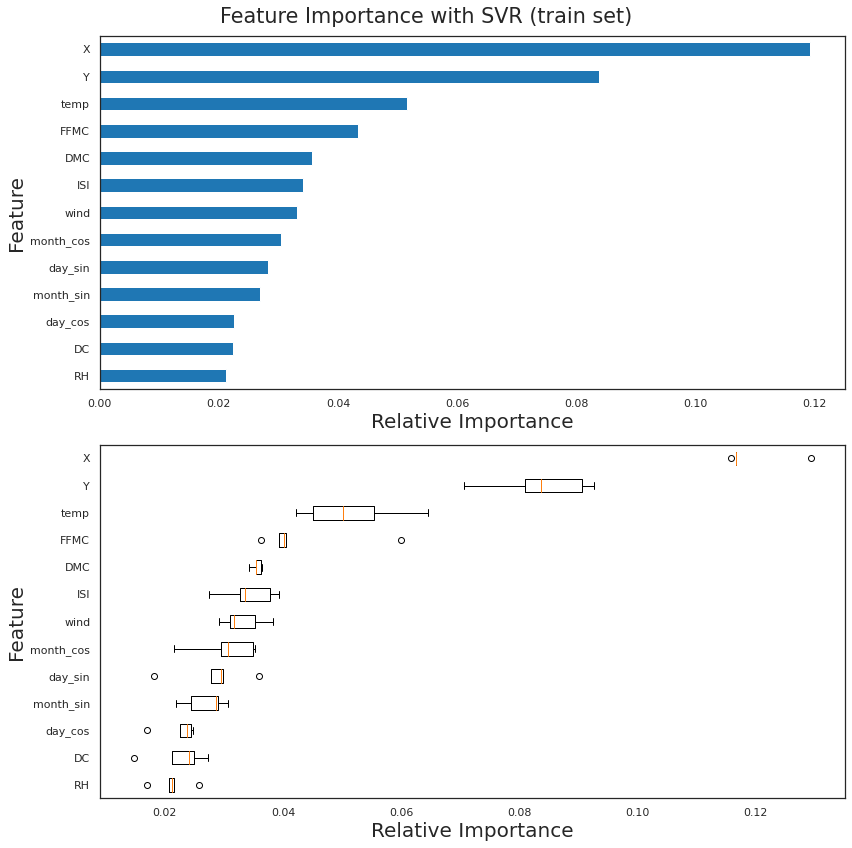

In [72]:
perm_imp(model = GR_SVR, x = X_train, y = y_train, title = 'Feature Importance with SVR (train set)')

#### Our top 3 important features for train set are the spatial co-oridnates 'X' and 'Y' and temperature.

In [73]:
def model_eval_plot(model, data, actual_y, title = 'Fitting of Model'):
    predicted_y = model.predict(data)
    
    plt.figure(figsize = (12,7))
    ax = sns.scatterplot(x = actual_y, y = predicted_y)
    xpoints = ypoints = plt.xlim()
    ax.plot(xpoints, ypoints, linestyle ='--', color = 'k', lw = 3)
    ax.set_xlabel("Test Values", fontsize = 20)
    ax.set_ylabel("Predicted Values", fontsize = 20)
    plt.title(title, size = "xx-large", pad = 15)
    plt.show()
    
    print('\n')
    print('Mean Absolute Deviation (MAD):', mean_absolute_error(actual_y, predicted_y))
    print('Root Mean Squared Error (RMSE):', mean_squared_error(actual_y, predicted_y, squared = False))
    print('\n')

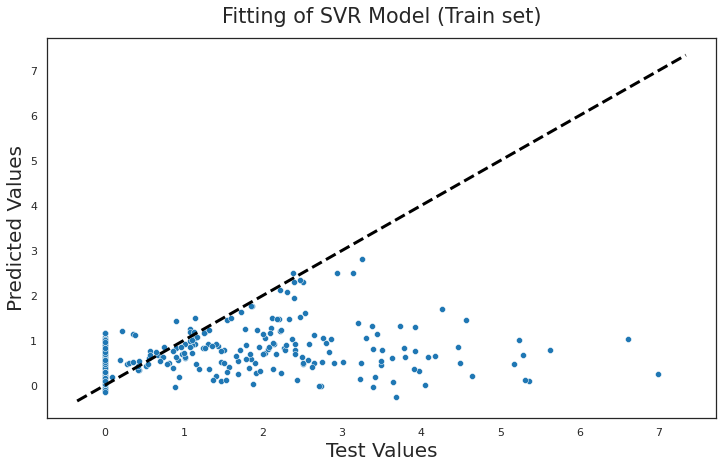



Mean Absolute Deviation (MAD): 0.9011467581824628
Root Mean Squared Error (RMSE): 1.4257180960798075




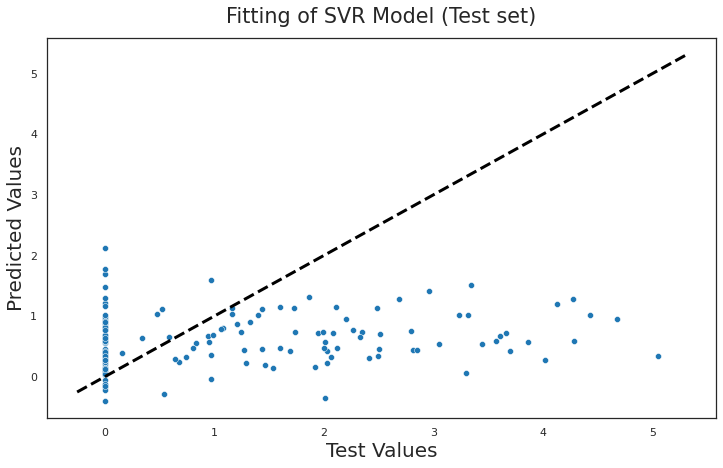



Mean Absolute Deviation (MAD): 1.0317183097787617
Root Mean Squared Error (RMSE): 1.4134209634071562




In [74]:
model_eval_plot(GR_SVR, X_train, y_train, 'Fitting of SVR Model (Train set)')
model_eval_plot(GR_SVR, X_test, y_test, 'Fitting of SVR Model (Test set)')

#### From the above plot we notice that SVR looks like a better model in comparison to the linear model. We again notice that the presence of large number of 0's seem to affect our model. Also, we see that the presence of large number of 0's is affecting our model our model predicts more accurately for smaller values of 'area' (small forest fires) than larger values (large forest fires)

# Ensemble Method for Decision Tree

## Random Forest Regressor

In [75]:
model = RandomForestRegressor(criterion = 'absolute_error', random_state = 7)
param_grid = {'n_estimators': [2,5,10,15,30,50,100,150],
              'min_samples_leaf': [1, 2, 5, 10],
              'max_features': [1, 2, 3]}
             
GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_RF = GR.fit(X_train,y_train)

idx = argmax(GR_RF.cv_results_['mean_test_MAE'])

result = {key : round((GR_RF.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_RF.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_RF.cv_results_['params'][idx]
all_GR['Random Forest'] = pd.Series(result)

print("Best MAE: %f using %s "%(GR_RF.best_score_,GR_RF.best_params_))

Best MAE: -1.124220 using {'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 150} 


#### Using grid search we obtained the best parameters for our RF model with MAE score of 1.124 for train set. Next we will check feature importance for the train set by our model.

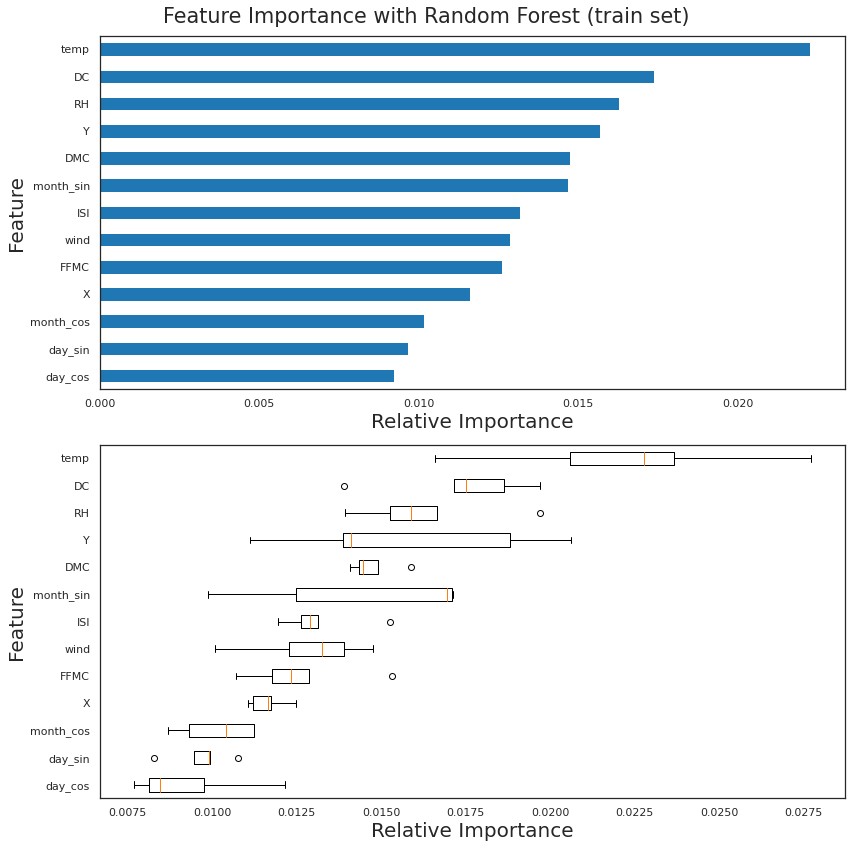

In [76]:
perm_imp(model = GR_RF, x = X_train, y = y_train, title = 'Feature Importance with Random Forest (train set)')

#### Our top 3 important features for train set are temperature, DC and RH.

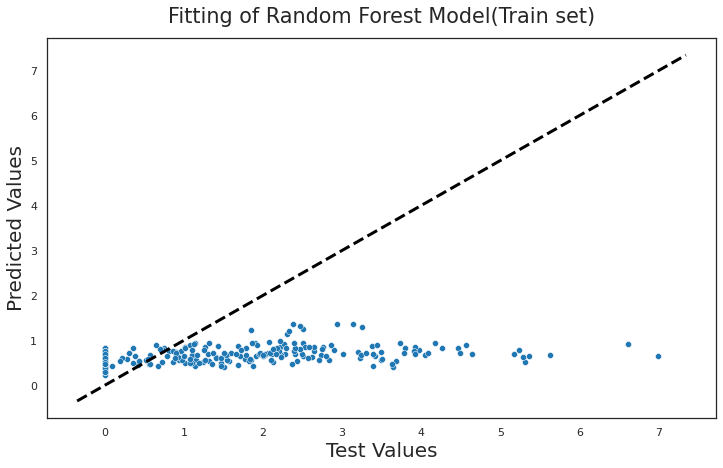



Mean Absolute Deviation (MAD): 1.0109258394212879
Root Mean Squared Error (RMSE): 1.4282284950690949




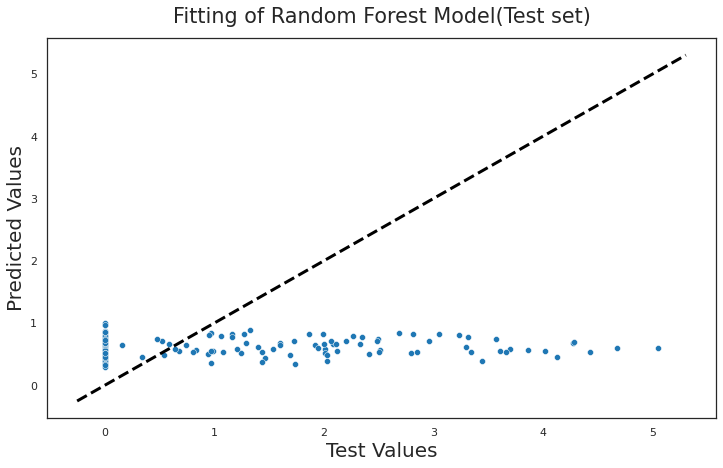



Mean Absolute Deviation (MAD): 1.0715634823190558
Root Mean Squared Error (RMSE): 1.4196614839789807




In [77]:
model_eval_plot(GR_RF, X_train, y_train, 'Fitting of Random Forest Model(Train set)')
model_eval_plot(GR_RF, X_test, y_test, 'Fitting of Random Forest Model(Test set)')

#### From the above plot we notice that RF model performs similar to SVR. We again notice that the presence of large number of 0's seem to affect our model. Also, we see that the presence of large number of 0's is affecting our model our model predicts more accurately for smaller values of 'area' (small forest fires) than larger values (large forest fires)

### Gradient Boosting Grid Search

In [78]:
model = GradientBoostingRegressor(loss = 'absolute_error', max_features = 5, random_state = 12)
param_grid = {'n_estimators': [2,4,5,6,8,10,12,15,30,50]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_GB = GR.fit(X_train,y_train)

print("Best MAE: %f using %s "%(GR_GB.best_score_,GR_GB.best_params_))

Best MAE: -1.050415 using {'n_estimators': 30} 


### GBC Error Rate Estimation

                Error
No_of_trees          
2            1.101844
4            1.088774
5            1.084282
6            1.081355
8            1.075212
10           1.070230
12           1.064992
15           1.058034
30           1.050415
50           1.056587


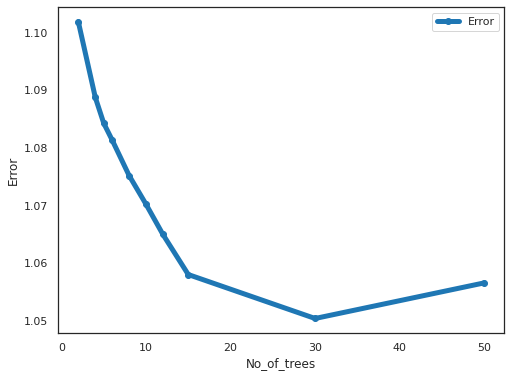

In [79]:
GBC_error = abs((GR_GB.cv_results_["mean_test_MAE"]))
GBC_error_df = pd.DataFrame({'No_of_trees':param_grid['n_estimators'] ,'Error': GBC_error}).set_index('No_of_trees')

print(GBC_error_df)

GBC_error_df.plot(marker = 'o', figsize= (8,6), linewidth = 5, ylabel = 'Error')
plt.show()

#### Graphical view of Gradient Boosting error rate estimation clearly showing error rate drops lowest at 30 number of trees and then starts increasing again after that.

#### Hence we will choose 30 as it will be the most optimum choice with regard to prediction and speed.

#### After choosing it we can do the grid search again to find other hyperparameters keeping no of trees constant at 30.

In [80]:
model = GradientBoostingRegressor(loss = 'absolute_error', n_estimators = 30, random_state = 10)
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              "subsample" : [1.0, 0.5],
              "max_features": [1, 2, 3],
              'min_samples_leaf': [1, 2, 5, 10]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_GB = GR.fit(X_train,y_train)

idx = argmax(GR_GB.cv_results_['mean_test_MAE'])

result = {key : round((GR_GB.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_GB.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_GB.cv_results_['params'][idx]
all_GR['Gradient Boosting'] = pd.Series(result)

print("Best MAE: %f using %s "%(GR_GB.best_score_,GR_GB.best_params_))

Best MAE: -1.060668 using {'learning_rate': 0.1, 'max_features': 3, 'min_samples_leaf': 2, 'subsample': 1.0} 


#### Using grid search we obtained the best parameters for our GB model with MAE score of 1.061 for train set. Now we will check feature importance for the train set by our model.

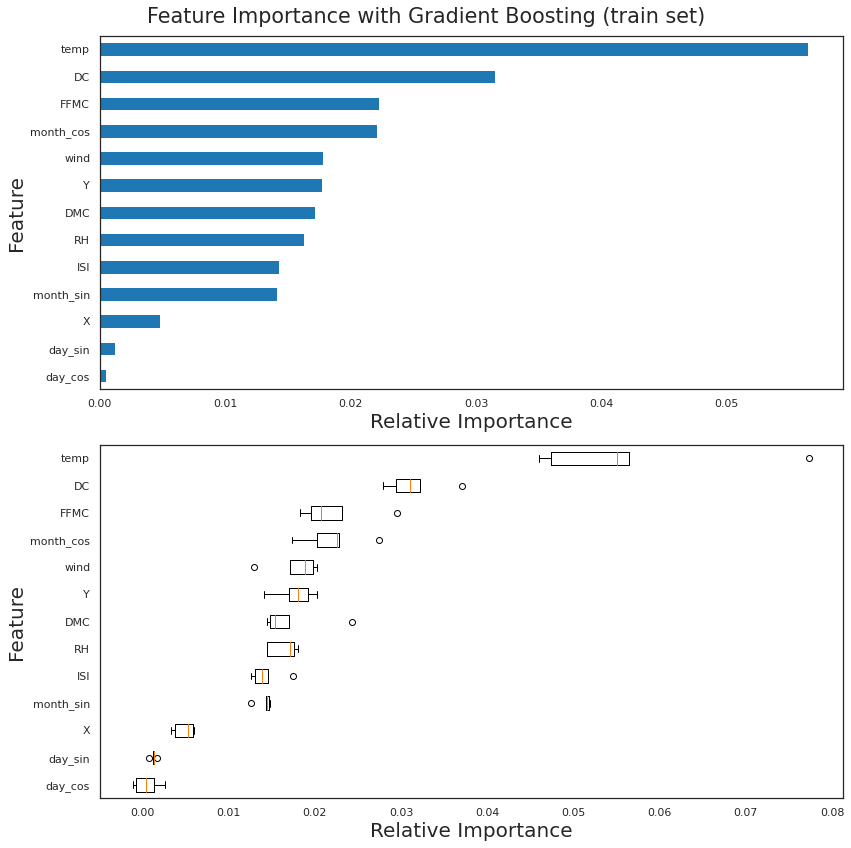

In [81]:
perm_imp(model = GR_GB, x = X_train, y = y_train, title = 'Feature Importance with Gradient Boosting (train set)')

#### Our top 3 important features for train set are temperature, DC and FFMC.

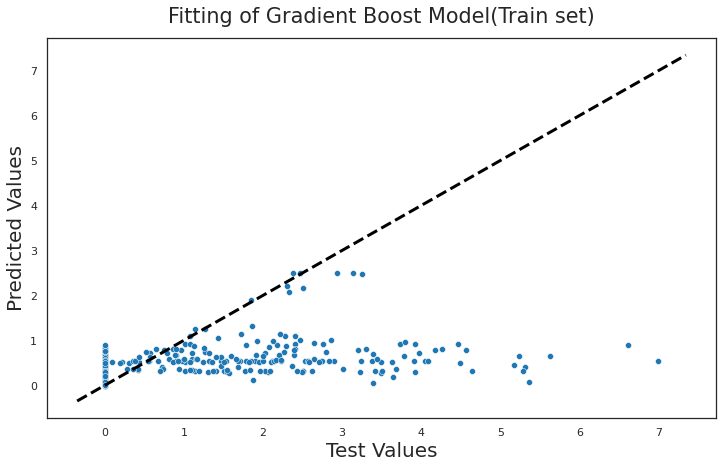



Mean Absolute Deviation (MAD): 0.951330919213502
Root Mean Squared Error (RMSE): 1.4651195396203955




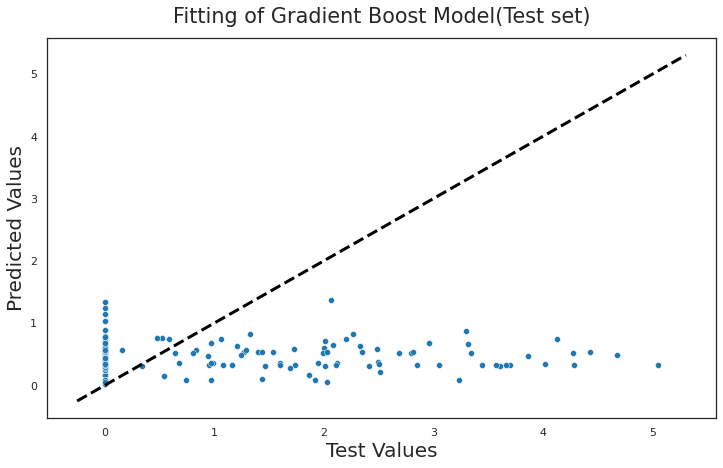



Mean Absolute Deviation (MAD): 1.0988623114768976
Root Mean Squared Error (RMSE): 1.5030599873355517




In [82]:
model_eval_plot(GR_GB, X_train, y_train, 'Fitting of Gradient Boost Model(Train set)')
model_eval_plot(GR_GB, X_test, y_test, 'Fitting of Gradient Boost Model(Test set)')

#### From the above plot we notice that GB model performs similar to SVR. We again notice that the presence of large number of 0's seem to affect our model. Also, we see that the presence of large number of 0's is affecting our model our model predicts more accurately for smaller values of 'area' (small forest fires) than larger values (large forest fires)

### Training Score and Parameters (STMFWI Setup)

#### Using grid search we found our most optimal hyper parameters for our 3 models for the first setup (STMFWI) and their average cross-val scores.

In [83]:
pd.DataFrame(all_GR)

,SVR,Random Forest,Gradient Boosting
MAE,-1.101,-1.124,-1.061
RMSE,-1.549,-1.513,-1.537
std_MAE,0.116,0.105,0.103
std_RMSE,0.164,0.154,0.17
params,"{'C': 3, 'gamma': 0.03}","{'max_features': 1, 'min_samples_leaf': 10, 'n...","{'learning_rate': 0.1, 'max_features': 3, 'min..."


### Metric scores for our 3 models for the first setup (STMFWI) on test data set

#### Now we will define a function for calculating our test scores for the 3 models so that we can compare them easily

In [84]:
# Function for calculating the metrics 

def model_test(x,y):
    models = [("SVR", GR_SVR), ("Random Forest", GR_RF), ("Gradient Boosting", GR_GB)]
    pred_metrics = dict()

    for name, model in models:
        model_predict = model.predict(x)
        pred = dict()        
        
        pred['MAE'] = mean_absolute_error(y, model_predict)
        pred['RMSE'] = mean_squared_error(y, model_predict, squared = False)
                
        pred_metrics[name] = pd.Series(pred)
    return pd.DataFrame(pred_metrics)

In [85]:
test_scores = model_test(X_test,y_test)

In [86]:
test_scores

,SVR,Random Forest,Gradient Boosting
MAE,1.031718,1.071563,1.098862
RMSE,1.413421,1.419661,1.503060


#### We notice SVR performs the best out of the 3 models, with MAE = 1.032 and RMSE = 1.413 followed by Random Forest.

#### We will now check feature importance for test set by our 3 models

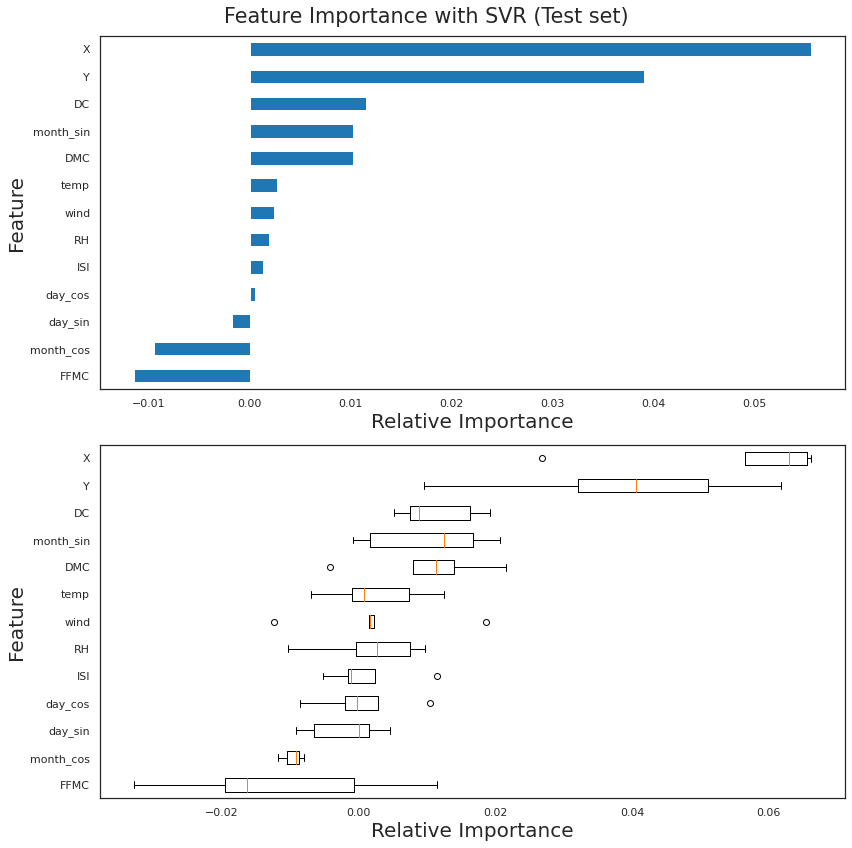

In [87]:
perm_imp(model = GR_SVR, x = X_test, y = y_test, title = 'Feature Importance with SVR (Test set)')

#### Our top 3 important features for train set are the spatial variables 'X' and 'Y' and DC.

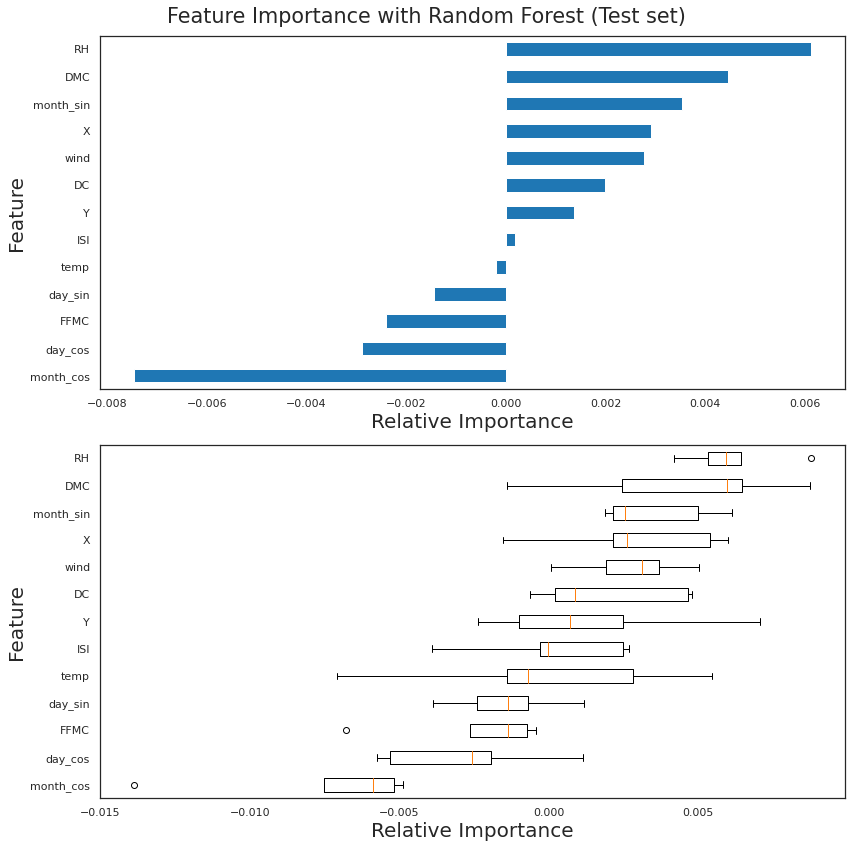

In [88]:
perm_imp(model = GR_RF, x = X_test, y = y_test, title = 'Feature Importance with Random Forest (Test set)')

#### Our top 3 important features for train set are RH, DMC and monthly_cos.

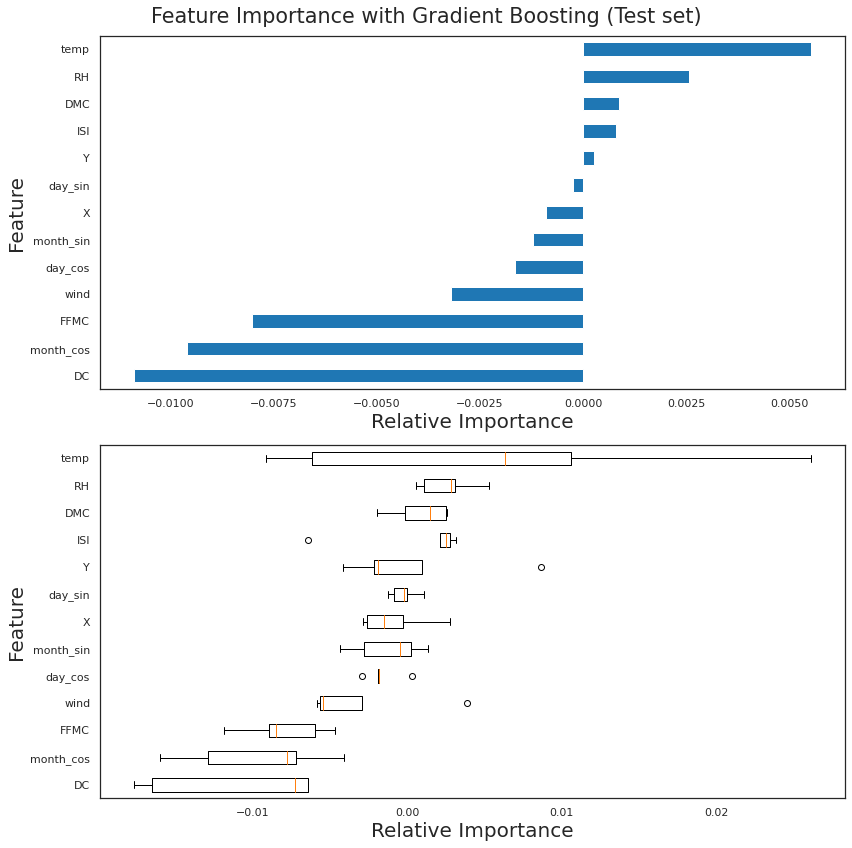

In [89]:
perm_imp(model = GR_GB, x = X_test, y = y_test, title = 'Feature Importance with Gradient Boosting (Test set)')

#### Our top 3 important features for train set are DC and FFMC and monthly_cos

## Regression Error Characteristic (REC) Curve

#### We will now define a function to calculate the error tolerance(in terms of the absolute deviation) and  accuracy (percentage of points predicted within the tolerance), so that we can compare our models using the REC curve.

#### Link for the research paper on REC curve by Jinbo Bi and Kristin P. Bennett :-
* http://homepages.rpi.edu/~bennek/papers/rec.pdf

In [90]:
### Function for REC

def rec_df(x_data, y_true, model):
    y_pred = model.predict(x_data)
    err = np.sort(abs(y_true - y_pred))
    err = np.insert(err, 0, 0)
    n = len(err)
    rec_x = np.ones((n,))
    rec_y = np.ones((n,))
    rec_x[0] = rec_y[0] = correct = absDev = 0
    for i in range(1,n):
        if (err[i] > err[i-1]):
            absDev = correct / n
        rec_x[i] = err[i]
        rec_y[i] = absDev
        correct = correct + 1
        
    rec_df = pd.DataFrame([rec_x, rec_y]).T
    rec_df.columns = ['x', 'y']
    return rec_df

#### After defining the REC function, we can use it to calculate tolerance and accuracy and then plot our REC curve for our 3 models

In [91]:
rec_sv = rec_df(X_test, y_test, GR_SVR)
rec_rf = rec_df(X_test, y_test, GR_RF)
rec_gb = rec_df(X_test, y_test, GR_GB)

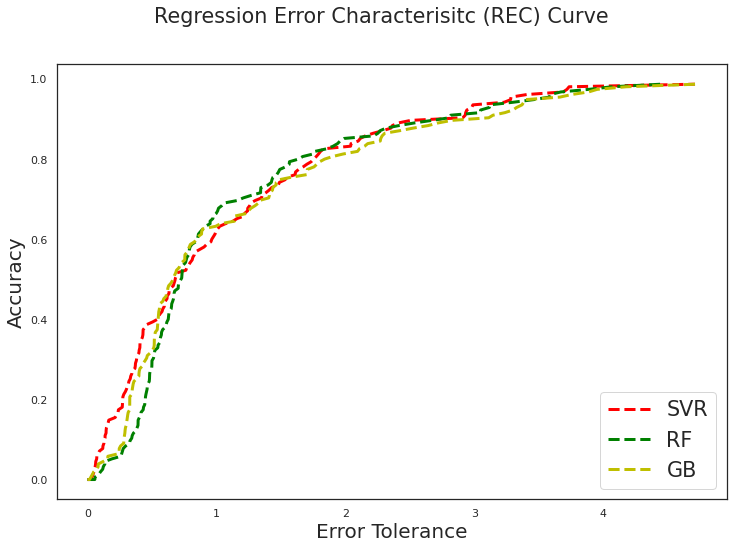

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rec_sv.x, rec_sv.y, linestyle='--', lw=3, color = 'r', label= "{0}".format('SVR'))
ax.plot(rec_rf.x, rec_rf.y, linestyle='--', lw=3, color = 'g', label= "{0}".format('RF'))
ax.plot(rec_gb.x, rec_gb.y, linestyle='--', lw=3, color = 'y', label= "{0}".format('GB'))

ax.legend(loc="lower right", fontsize = 'xx-large')    
ax.set_xlabel("Error Tolerance", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
plt.suptitle("Regression Error Characterisitc (REC) Curve", fontsize = 'xx-large')
plt.show()

## Saving Best Model with Most Optimum Parameters (STMFWI Setup)

#### Lastly we will our SVR model for 1st setup and then later fit it in our pipeline.

In [93]:
joblib.dump(GR_SVR, 'best_model_SVR_1')

['best_model_SVR_1']

# Modelling (FWI Setup)

#### We will now train and test our Data Mining (DM) algorithms on our 2nd feature selection setup FWI i.e. selecting only the four FWI components.
#### We will use the same procedure as before for building our model by training using grid search and then testing.

In [94]:
setup2_features = ['FFMC', 'DMC', 'DC', 'ISI']

In [95]:
X_train2 = X_train[X_train.columns.intersection(setup2_features)]
X_test2 = X_test[X_test.columns.intersection(setup2_features)]

In [96]:
print(X_train2)
print(X_test2)

         FFMC       DMC        DC       ISI
0    0.185662  0.376605 -1.391951 -0.320000
1    0.038249  0.001427 -0.656241 -0.586667
2    0.520196 -0.162625  0.174174  0.133333
3    0.391692 -1.039943 -0.022098 -0.453333
4   -0.921256  1.751783 -0.277417  0.000000
..        ...       ...       ...       ...
354 -1.775375  0.388017  0.278271  3.440000
355  1.886146 -0.497860 -0.035808 -1.386667
356 -0.159119  0.631954  0.029447  1.573333
357  0.000000 -0.853067 -0.163450  0.720000
358  1.248739 -0.446505 -0.156135 -0.906667

[359 rows x 4 columns]
         FFMC       DMC        DC        ISI
0    1.225215 -0.800285  1.256571  -0.906667
1    0.185662 -0.199715 -0.528858   0.000000
2   -0.329034  0.182596 -0.075089   0.053333
3   -1.279765 -0.171184  1.128099  12.720000
4    0.113040  0.486448  0.240802   0.586667
..        ...       ...       ...        ...
149  1.318014 -1.329529  1.336579  -0.346667
150 -0.921256 -0.390870 -0.132336   2.533333
151  0.488683  2.592011 -4.322541  -0.26666

In [97]:
all_GR2 = dict()

## Support Vector Machine (Gaussian) Grid Search

In [98]:
model = SVR(kernel = 'rbf')
param_grid = dict(gamma = gamma, C = c)

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    

GR_SVR = GR.fit(X_train2,y_train)

idx = argmax(GR_SVR.cv_results_['mean_test_MAE'])

result = {key : round((GR_SVR.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_SVR.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_SVR.cv_results_['params'][idx]
all_GR2['SVR'] = pd.Series(result)

print("Best MAE score: %f using %s "%(GR_SVR.best_score_,GR_SVR.best_params_))

Best MAE score: -1.112433 using {'C': 0.1, 'gamma': 3} 


#### Using grid search we obtained the best parameters for our SVR model with MAE score of 1.112 for train set. Now we will check feature importance for the train set by our model.

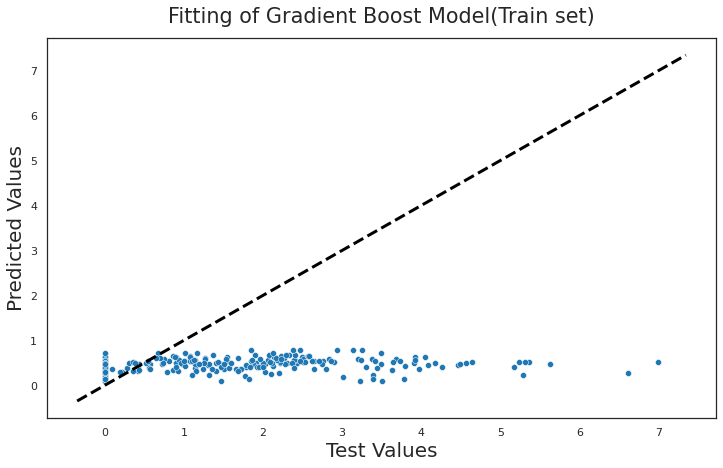



Mean Absolute Deviation (MAD): 1.022172903571719
Root Mean Squared Error (RMSE): 1.5421823866162885




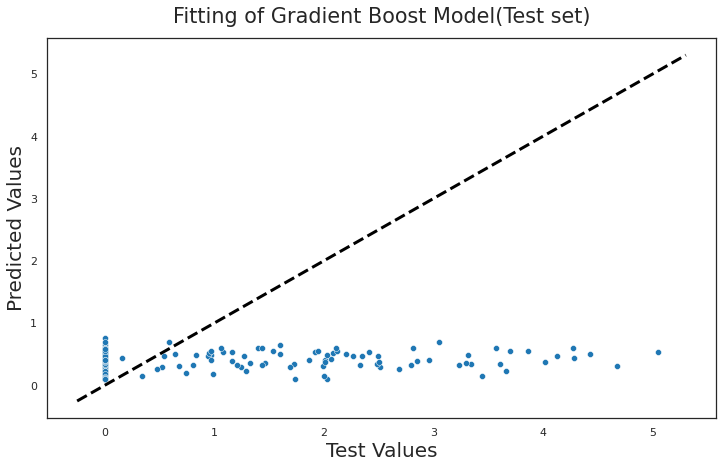



Mean Absolute Deviation (MAD): 1.0587074939804
Root Mean Squared Error (RMSE): 1.495031154508141




In [99]:
model_eval_plot(GR_SVR, X_train2, y_train, 'Fitting of Gradient Boost Model(Train set)')
model_eval_plot(GR_SVR, X_test2, y_test, 'Fitting of Gradient Boost Model(Test set)')

## Random Forest Regressor

In [100]:
model = RandomForestRegressor(criterion = 'absolute_error', random_state = 7)
param_grid = {'n_estimators': [2,5,10,15,30,50,100,150],
              'min_samples_leaf': [1, 2, 5, 10],
              'max_features': [1, 2, 3]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_RF = GR.fit(X_train2,y_train)

idx = argmax(GR_RF.cv_results_['mean_test_MAE'])

result = {key : round((GR_RF.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_RF.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_RF.cv_results_['params'][idx]
all_GR2['Random Forest'] = pd.Series(result)

print("Best MAE: %f using %s "%(GR_RF.best_score_,GR_RF.best_params_))

Best MAE: -1.146641 using {'max_features': 1, 'min_samples_leaf': 5, 'n_estimators': 30} 


#### Using grid search we obtained the best parameters for our RF model with MAE score of 1.103 for train set. Now we will check feature importance for the train set by our model.

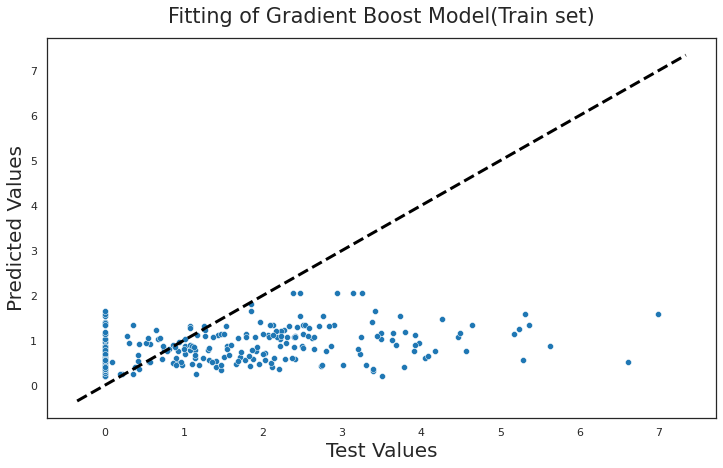



Mean Absolute Deviation (MAD): 0.9520309535588456
Root Mean Squared Error (RMSE): 1.3372574825193386




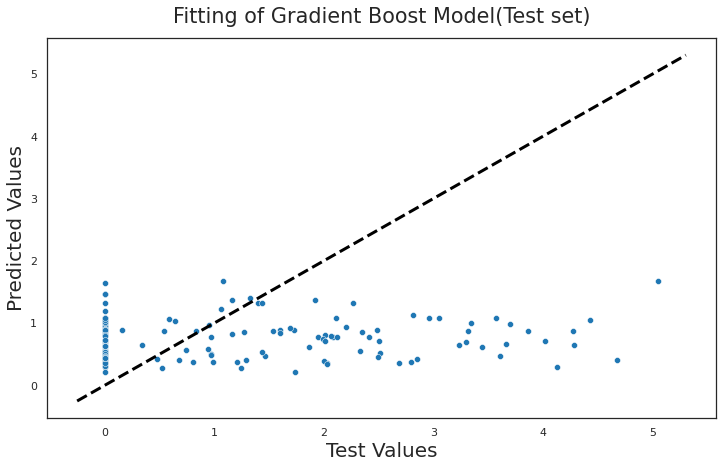



Mean Absolute Deviation (MAD): 1.091575483557879
Root Mean Squared Error (RMSE): 1.3944061386744946




In [101]:
model_eval_plot(GR_RF, X_train2, y_train, 'Fitting of Gradient Boost Model(Train set)')
model_eval_plot(GR_RF, X_test2, y_test, 'Fitting of Gradient Boost Model(Test set)')

### Gradient Boosting Grid Search

In [102]:
model = GradientBoostingRegressor(loss = 'absolute_error', max_features = 2, random_state = 12)
param_grid = {'n_estimators': [2,5,10,15,30,50,100]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_GB = GR.fit(X_train2,y_train)

print("Best MAE: %f using %s "%(GR_GB.best_score_,GR_GB.best_params_))

Best MAE: -1.110380 using {'n_estimators': 50} 


### GBC Error Rate Estimation

                Error
No_of_trees          
2            1.116598
5            1.117824
10           1.117512
15           1.113880
30           1.110476
50           1.110380
100          1.118465


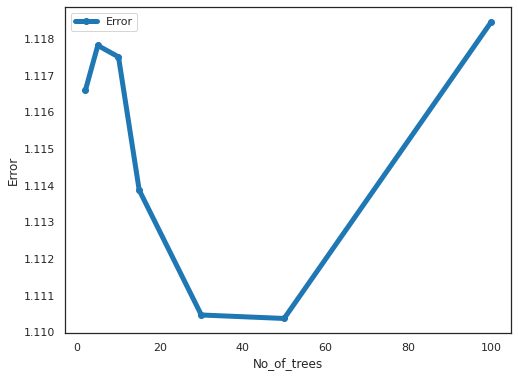

In [103]:
GBC_error = abs((GR_GB.cv_results_["mean_test_MAE"]))
GBC_error_df = pd.DataFrame({'No_of_trees': param_grid['n_estimators'] ,'Error': GBC_error}).set_index('No_of_trees')

print(GBC_error_df)

GBC_error_df.plot(marker = 'o', figsize= (8,6), linewidth = 5, ylabel = 'Error')
plt.show()

#### Graphical view of Gradient Boosting error rate estimation clearly showing error rate drops lowest at 30-50 number of trees and then starts increasing again after that.

#### Hence we will choose 30 as it will be the most optimum choice with regard to prediction and speed.

#### After choosing it we can do the grid search again to find other hyperparameters keeping no of trees constant at 30.

In [104]:
model = GradientBoostingRegressor(loss = 'absolute_error', n_estimators = 30, random_state = 10)
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              "subsample" : [1.0, 0.5],
              "max_features": [1, 2, 3],
              'min_samples_leaf': [1, 2, 5, 10]}

GR = GridSearchCV(estimator = model, param_grid = param_grid, 
                  scoring = metrics_def, cv = fold, refit = "MAE", n_jobs = -1)    
GR_GB = GR.fit(X_train2,y_train)

idx = argmax(GR_GB.cv_results_['mean_test_MAE'])

result = {key : round((GR_GB.cv_results_["mean_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()}
result.update({"std_{0}".format(key) : round((GR_GB.cv_results_["std_test_{0}".format(key)][idx]),3) for key in metrics_def.keys()})
result['params'] = GR_GB.cv_results_['params'][idx]
all_GR2['Gradient Boosting'] = pd.Series(result)

print("Best MAE: %f using %s "%(GR_GB.best_score_,GR_GB.best_params_))

Best MAE: -1.103463 using {'learning_rate': 0.1, 'max_features': 1, 'min_samples_leaf': 2, 'subsample': 1.0} 


#### Using grid search we obtained the best parameters for our GB model with MAE score of 1.103 for train set. Now we will check feature importance for the train set by our model.

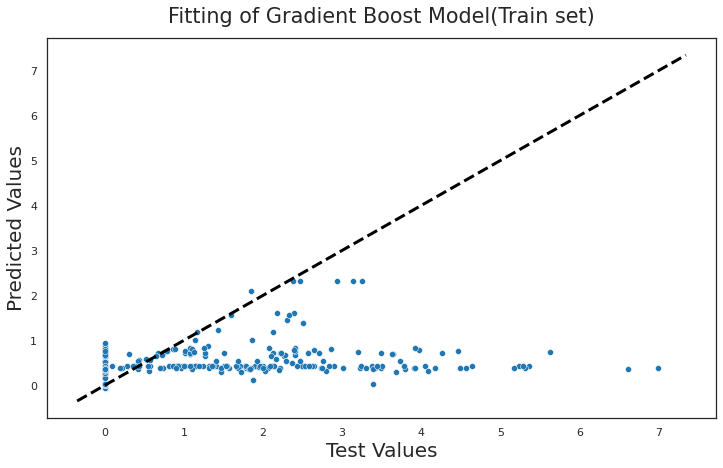



Mean Absolute Deviation (MAD): 0.9946542889734906
Root Mean Squared Error (RMSE): 1.5059407519626653




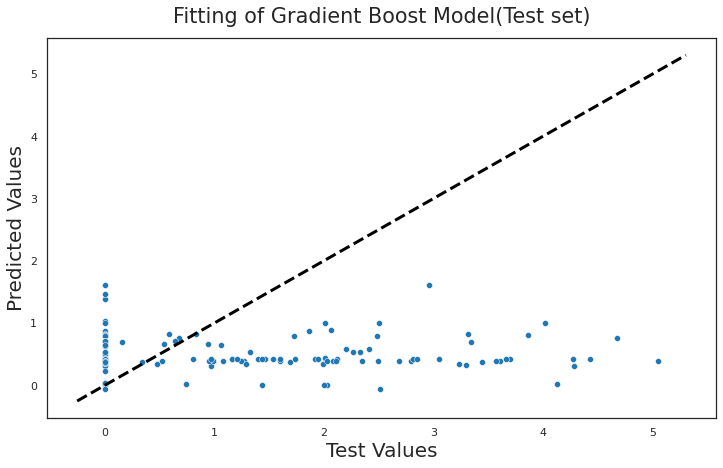



Mean Absolute Deviation (MAD): 1.097822245106827
Root Mean Squared Error (RMSE): 1.4920443704191684




In [105]:
model_eval_plot(GR_GB, X_train2, y_train, 'Fitting of Gradient Boost Model(Train set)')
model_eval_plot(GR_GB, X_test2, y_test, 'Fitting of Gradient Boost Model(Test set)')

### Training Score and Parameters (FWI Setup)

#### Using grid search we found our most optimal hyper parameters for our 3 models for the second setup (FWI) and their average cross-val scores.

In [106]:
pd.DataFrame(all_GR2)

,SVR,Random Forest,Gradient Boosting
MAE,-1.112,-1.147,-1.103
RMSE,-1.594,-1.525,-1.578
std_MAE,0.116,0.097,0.11
std_RMSE,0.175,0.143,0.173
params,"{'C': 0.1, 'gamma': 3}","{'max_features': 1, 'min_samples_leaf': 5, 'n_...","{'learning_rate': 0.1, 'max_features': 1, 'min..."


### Metric scores for our 3 models for the first setup (STMFWI) on test data set

In [107]:
test_scores2 = model_test(X_test2,y_test)

In [108]:
test_scores2

,SVR,Random Forest,Gradient Boosting
MAE,1.058707,1.091575,1.097822
RMSE,1.495031,1.394406,1.492044


#### We notice SVR performs the best out of the 3 models, with MAE = 1.059, which is our primary metric however it has RMSE = 1.495 which is the highest and model RF has the lowest RMSE of 1.394.

## Regression Error Characterisitc (REC) Curve

In [109]:
rec_sv = rec_df(X_test2, y_test, GR_SVR)
rec_rf = rec_df(X_test2, y_test, GR_RF)
rec_gb = rec_df(X_test2, y_test, GR_GB)

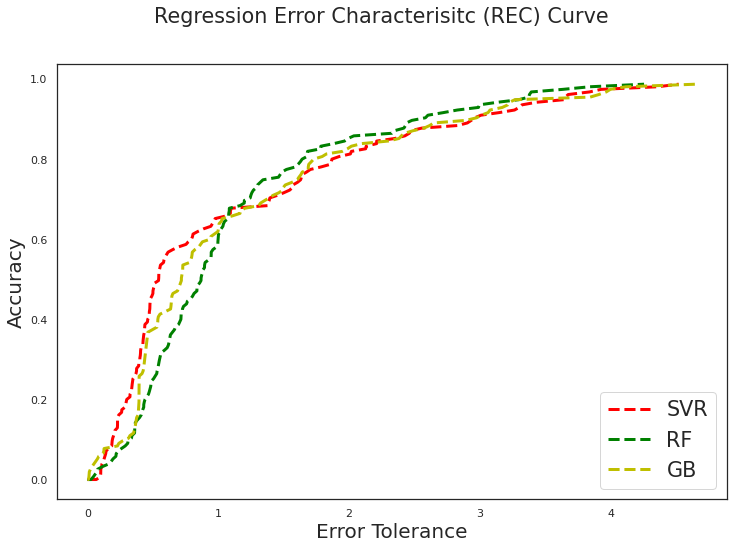

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(rec_sv.x, rec_sv.y, linestyle='--', lw=3, color = 'r', label= "{0}".format('SVR'))
ax.plot(rec_rf.x, rec_rf.y, linestyle='--', lw=3, color = 'g', label= "{0}".format('RF'))
ax.plot(rec_gb.x, rec_gb.y, linestyle='--', lw=3, color = 'y', label= "{0}".format('GB'))

ax.legend(loc="lower right", fontsize = 'xx-large')    
ax.set_xlabel("Error Tolerance", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
plt.suptitle("Regression Error Characterisitc (REC) Curve", fontsize = 'xx-large')
plt.show()

## Saving Best Model with Most Optimum Parameters

#### Lastly we will our SVR model and then later fit it in our pipeline.

In [111]:
joblib.dump(GR_SVR, 'best_model_SVR_2')

['best_model_SVR_2']

# Conclusion

#### Hence we can say that we can use the first setup – STMFWI to get more accurate prediction for a specific location and time using SVR model. However we should note that it will be more time consuming, costlier and require more man power in collecting some specific data like location. 

#### For general purpose only the four FWI components (FFMC , DMC, DC, ISI) seem sufficient in giving a very accurate prediction using the SVR model .We can monitor these using a remote sensing satellite and thus be able detect forest fires and their intensity in real time. Hence, this seems like a better practical approach in detecting and suppressing forest fires in time and would be helpful for the forest and government institutions in managing their resources efficiently.

# Additional Comments / Suggestions 

#### We can try fitting a different model or use an advaned technique as follows:-
* Using Poisson Zero Inflated Model and rounding off(discretizing) the outcome variable, 
* Discretizing outcome variable into categorical variable by binning them and then using classification methods, 
* Using 2 separate models or a mixture model - With 0 values and other without 0's (Separate models is easier than mixture modelling), 
* Using some advanced upsampling/downsampling techniques like SmoteR (https://core.ac.uk/download/pdf/29202178.pdf) or SMOGN (http://proceedings.mlr.press/v74/branco17a/branco17a.pdf.)
* Using an advanced technique like Density-based Weighting (https://link.springer.com/article/10.1007/s10994-021-06023-5)
* Tweedie Zero gradient boosting for extremely unbalanced zero inflated data (https://www.math.mcgill.ca/yyang/resources/papers/CSSC_EMTboost.pdf)

#### Try different scaling method

#### Note: In the next part we will build a custom pipeline that will help us automate these tasks and thus will simplify our deployment process in the end.